# OCR - Fundamentals and Practical Applications with PyTesseract

## Dependencies installation

In [7]:
!pip install pytesseract opencv-python-headless

In [2]:
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (12.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [86]:
# All the required dep
from cv2.typing import MatLike
from google.colab.patches import cv2_imshow
from typing import List, Union
import requests
import cv2
import pytesseract
import numpy as np

In [ ]:
"""
In case of Windows users perform the following step:

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
"""

In [90]:
class Image:
    """
    A class to handle image processing and text detection using OCR (Optical Character Recognition).

    Attributes:
        img_url (str): URL of the image to be processed.
        lang (str): Language for OCR, default is 'eng' (English).
        detected_text (str): Detected text from the image.
        img (np.ndarray): The image array loaded from the URL.
        image_with_contours (np.ndarray): The image with contours drawn around detected objects.
        thresh (np.ndarray): Thresholded image used for edge detection.

    Methods:
        __init__(img_url: str, lang='eng') -> None:
            Initializes the Image object with the provided image URL and language.

        download() -> None:
            Downloads the image from the URL and decodes it into an OpenCV image array.

        show() -> None:
            Displays the original image and the image with contours side by side.

        preprocess() -> np.ndarray:
            Converts the image to grayscale, applies a median blur, performs adaptive thresholding, and edge detection.

        find_contours(edges: np.ndarray) -> List[np.ndarray]:
            Finds contours in the edge-detected image and stores the image with contours.

        detect_text(contours: List[np.ndarray]) -> None:
            Draws bounding boxes around detected contours and extracts text from the image using OCR.

        run() -> None:
            Executes the full image processing pipeline: preprocessing, contour finding, text detection, and displaying the results.
    """

    def __init__(self, img_url: str, lang='eng') -> None:
        """
        Initializes the Image object.

        Args:
            img_url (str): URL of the image to be processed.
            lang (str): Language for OCR (default is 'eng').

        Raises:
            Exception: If the specified language is not available for OCR.
        """
        if lang not in pytesseract.get_languages(config=''):
            raise Exception(f'{lang}: Language not available.')

        self.lang = lang
        self.img_url = img_url
        self.download()
        self.detected_text: str = ''

    @property
    def detected_text(self) -> str:
        """
        Gets the detected text from the image.

        Returns:
            str: The detected text.
        """
        return self._detected_text

    @detected_text.setter
    def detected_text(self, text: str) -> None:
        """
        Sets the detected text.

        Args:
            text (str): The text detected from the image.
        """
        self._detected_text = text

    def run(self) -> None:
        """
        Executes the full image processing pipeline: preprocessing, contour finding, text detection,
        and displaying the results.
        """
        edges = self.preprocess()
        contours = self.find_contours(edges)
        self.detect_text(contours)

        print("Detected text:", self.detected_text)

        self.show()

    def download(self) -> None:
        """
        Downloads the image from the URL and decodes it into an OpenCV image array.
        """
        response = requests.get(self.img_url)
        img_array = np.array(bytearray(response.content), dtype=np.uint8)
        self.img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

    def show(self) -> None:
        """
        Displays the original image and the image with contours side by side.
        """
        if hasattr(self, 'image_with_contours'):
            cv2_imshow(np.concatenate((self.img, self.image_with_contours), axis=1))
        else:
            raise ValueError("Image with contours is not available. Run the processing pipeline first.")

    def preprocess(self) -> np.ndarray:
        """
        Converts the image to grayscale, applies a median blur, performs adaptive thresholding,
        and edge detection.

        Returns:
            np.ndarray: The edge-detected image.
        """
        gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        gray = cv2.medianBlur(gray, 7)
        self.thresh = cv2.adaptiveThreshold(gray,
                                            255,
                                            cv2.ADAPTIVE_THRESH_MEAN_C,
                                            cv2.THRESH_BINARY,
                                            15,
                                            13)
        edges = cv2.Canny(self.thresh, 0, 100)
        return edges

    def find_contours(self, edges: np.ndarray) -> List[np.ndarray]:
        """
        Finds contours in the edge-detected image and stores the image with contours.

        Args:
            edges (np.ndarray): The edge-detected image.

        Returns:
            List[np.ndarray]: A list of contours found in the image.
        """
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        self.image_with_contours = self.img.copy()
        return contours

    def detect_text(self, contours: List[np.ndarray]) -> None:
        """
        Draws bounding boxes around detected contours and extracts text from the image using OCR.

        Args:
            contours (List[np.ndarray]): A list of contours to draw bounding boxes around.
        """
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(self.image_with_contours,
                          (x, y),
                          (x + w, y + h),
                          (255, 0, 0),
                          2)
        text = pytesseract.image_to_string(self.img, lang=self.lang)

        if text:
            self.detected_text += text

Detected text: PRIDE & PREJUDICE.

CHAPTER I.

Ip is a troth univer ally acknow-
ledged, that a single man in posses-
sion of a good fortune, must be in
want of a wife.
However little known the feelings
or views of such a man may be on
_his first entering a neighbourhood,
~ this truth is so well fixed in the minds

of some one or other of their daugh-
ters.

 



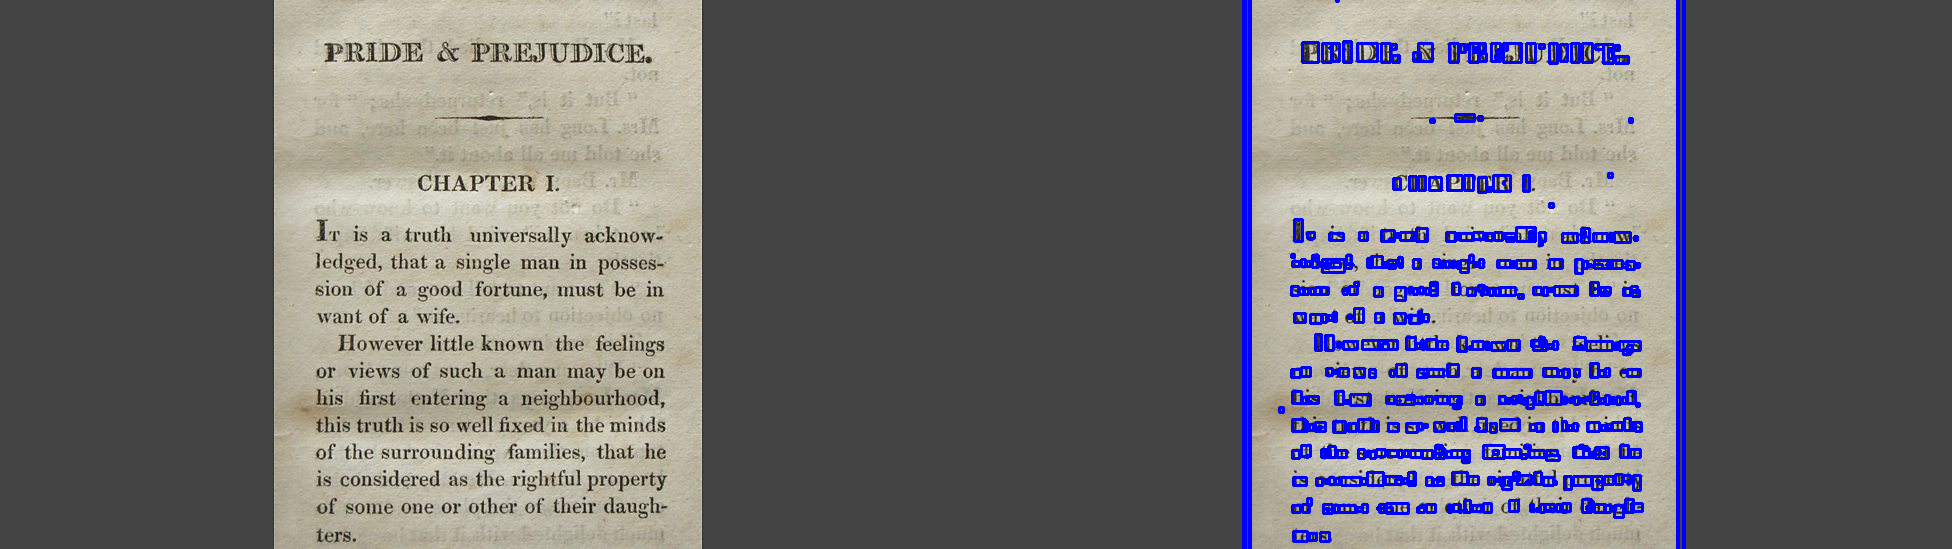

In [88]:
# Pride and Prejudice fragment
URL: str = 'https://ichef.bbci.co.uk/images/ic/976x549_b/p01sds21.jpg'

image: Image = Image(img_url=URL, lang='eng')
image.run()